In [1]:
import cv2
import numpy as np

import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from itertools import product

dir_in  = "/home/gzguevara/laser/media/input/middle_girl.mp4"
dir_out = "/home/gzguevara/laser/media/output/first_complete.mp4"

# G-Streamer Pipelines

In [2]:
def gstr_in(file_path):
    return (
        "filesrc location=%s ! "
        "qtdemux ! " #for mp4 files
        "h264parse ! "
        "nvv4l2decoder ! "
        "nvvidconv ! "
        "video/x-raw, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! "
        "appsink"
        % (file_path)
    )

pipe_in  = gstr_in(dir_in)
pipe_in  = cv2.VideoCapture(pipe_in, cv2.CAP_GSTREAMER)

Opening in BLOCKING MODE 


NvMMLiteOpen : Block : BlockType = 261 
NVMEDIA: Reading vendor.tegra.display-size : status: 6 
NvMMLiteBlockCreate : Block : BlockType = 261 
[ WARN:0] global /tmp/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1063) open OpenCV | GStreamer warning: unable to query duration of stream
[ WARN:0] global /tmp/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=1, value=1, duration=-1


In [3]:
width  = int(pipe_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
height = int(pipe_in.get(cv2.CAP_PROP_FRAME_WIDTH))
fps    = int(pipe_in.get(cv2.CAP_PROP_FPS))

def gstr_out(file_path):
    return (
        "appsrc ! "
        "videoconvert ! "
        "video/x-raw, format=(string)RGBA ! "
        "nvvidconv ! "
        "nvv4l2h264enc ! "
        "h264parse ! "
        "qtmux ! "
        "filesink location=%s sync=false" 
        % (file_path)
    )

pipe_out = gstr_out(dir_out)
pipe_out = cv2.VideoWriter(pipe_out, cv2.CAP_GSTREAMER, 0, fps, (width, height), True) #True if rgb

Opening in BLOCKING MODE 


NvMMLiteOpen : Block : BlockType = 4 
===== NVMEDIA: NVENC =====
NvMMLiteBlockCreate : Block : BlockType = 4 


# Cuda Needs

In [4]:
def get_engine(engine_file_path=None):
    with open(engine_file_path, "rb") as f, trt.Runtime(trt.Logger(trt.Logger.WARNING)) as runtime:
        return runtime.deserialize_cuda_engine(f.read())
    
def allocate_buffers_um_pinned(engine):
    
    inputs, outputs, bindings = [], [], []
    
    for binding in engine:

        size  = trt.volume(engine.get_binding_shape(binding)) #* engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))

        # Allocate SINGLE pinned memory buffer
        mem = cuda.pagelocked_empty(size, dtype)
        
        # Append the device buffer to device bindings.
        bindings.append(int(mem.base.get_device_pointer()))
        
        # Append to the appropriate list.
        if engine.binding_is_input(binding): inputs.append(mem)
        else:                                outputs.append(mem)
    
    return inputs, outputs, bindings


# Preprocess Functions

In [5]:
#DexiNed
def dexi_pre(frame):

    frame = np.array(frame, dtype=np.float32)
    frame -= [103.939, 116.779, 123.68] #Mean subtraction
    frame = np.transpose(frame, (2, 0, 1)) #Move channels to the first index
    frame = np.expand_dims(frame, axis=0) 
    frame = frame.ravel()

    return frame

def sig(x): return 1 / (1 + np.exp(-x))

def dexi_post(frame):

    frame = 1 / (1 + np.exp(-frame))
    frame = frame * 255 #Normalization also possible
    frame = frame.reshape((512, 512)) 
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    #frame = frame.astype(np.uint8)

    return frame


In [6]:
#Face Detection
def facenet_pre(image):
    image = cv2.resize(image, (160, 120))
    image = np.asarray(image, dtype="float32")
    image = image.transpose(2, 0, 1)
    image = image.ravel()
    
    return image

min_sizes = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
steps     = [8, 16, 32, 64]
variance  = [0.1, 0.2]

def priorGen(min_sizes, steps):
    
    w, h = (160, 120)
    feature_map_2th = [int(int((h + 1) / 2) / 2), int(int((w + 1) / 2) / 2)]
    feature_map_3th = [int(feature_map_2th[0] / 2), int(feature_map_2th[1] / 2)]
    feature_map_4th = [int(feature_map_3th[0] / 2), int(feature_map_3th[1] / 2)]
    feature_map_5th = [int(feature_map_4th[0] / 2), int(feature_map_4th[1] / 2)]
    feature_map_6th = [int(feature_map_5th[0] / 2), int(feature_map_5th[1] / 2)]

    feature_maps = [
        feature_map_3th,
        feature_map_4th,
        feature_map_5th,
        feature_map_6th,
    ]

    priors = []
    for k, f in enumerate(feature_maps):
        _min_sizes = min_sizes[k]
        
        for i, j in product(range(f[0]), range(f[1])):  # i->h, j->w
            for min_size in _min_sizes:
                s_kx = min_size / w
                s_ky = min_size / h

                cx = (j + 0.5) * steps[k] / w
                cy = (i + 0.5) * steps[k] / h

                priors.append([cx, cy, s_kx, s_ky])

    return np.array(priors, dtype=np.float32) #priors

def decode(outputBlob, priors, variance):

    loc  = np.array(outputBlob[0]).reshape([-1, 14])
    conf = np.array(outputBlob[1]).reshape([-1, 2])
    iou  = np.array(outputBlob[2]).reshape([-1, 1])

    # get score
    cls_scores = conf[:, 1]
    iou_scores = iou[:, 0]

    # clamp
    _idx = np.where(iou_scores < 0.0)
    iou_scores[_idx] = 0.0

    _idx = np.where(iou_scores > 1.0)
    iou_scores[_idx] = 1.0

    scores = np.sqrt(cls_scores * iou_scores)
    scores = scores[:, np.newaxis]

    scale = np.array((160, 120))

    # get bboxes
    bboxes = np.hstack(((priors[:, 0:2]+ loc[:, 0:2] * variance[0] * priors[:, 2:4]) * scale, (priors[:, 2:4] * np.exp(loc[:, 2:4] * variance)) * scale,))
    # (x_c, y_c, w, h) -> (x1, y1, w, h)
    bboxes[:, 0:2] -= bboxes[:, 2:4] / 2

    # get landmarks
    landmarks = np.hstack(
        (
            (priors[:, 0:2] + loc[:, 4:6] * variance[0] * priors[:, 2:4]) * scale,
            (priors[:, 0:2] + loc[:, 6:8] * variance[0] * priors[:, 2:4]) * scale,
            (priors[:, 0:2] + loc[:, 8:10] * variance[0] * priors[:, 2:4]) * scale,
            (priors[:, 0:2] + loc[:, 10:12] * variance[0] * priors[:, 2:4]) * scale,
            (priors[:, 0:2] + loc[:, 12:14] * variance[0] * priors[:, 2:4]) * scale,
        )
    )

    return np.hstack((bboxes, landmarks, scores))

priors = priorGen(min_sizes, steps)

def facedet_post(output_blob, priors=priors, variance=variance):
    # Decode
    dets = decode(output_blob, priors, variance)

    # NMS
    keepIdx = cv2.dnn.NMSBoxes(
        bboxes=dets[:, 0:4].tolist(),
        scores=dets[:, -1].tolist(),
        score_threshold=0.6, #self._conf_threshold,
        nms_threshold=0.3, #self._nms_threshold,
        top_k=5000,#self._top_k,
    )  # box_num x class_num

    if len(keepIdx) > 0:
        dets = dets[keepIdx]
        #dets = np.squeeze(dets, axis=1)
        return dets[: 5000] #self._top_k
    
    else:
        return np.empty(shape=(0, 15))

# Main Loop

In [7]:
dir_engine_dexi    = '/home/gzguevara/laser/engines/dexi_cat_block.trt'
dir_engine_facedet = '/home/gzguevara/laser/engines/face_detection_yunet_2022mar.trt'
dir_engine_lmk     = '/home/gzguevara/laser/engines/landmarks.trt'

In [8]:
#Build an engine
engine_dexi    = get_engine(dir_engine_dexi)
engine_facedet = get_engine(dir_engine_facedet)
engine_lmk     = get_engine(dir_engine_lmk)

#Allocate buffers and create a stream
stream_dexi    = cuda.Stream()
stream_facedet = cuda.Stream()
stream_lmk = cuda.Stream()

#Get locations
in_dexi, out_dexi, bind_dexi          = allocate_buffers_um_pinned(engine_dexi)
in_facedet, out_facedet, bind_facedet = allocate_buffers_um_pinned(engine_facedet)
in_lmk, out_lmk, bind_lmk             = allocate_buffers_um_pinned(engine_lmk)


with engine_dexi.create_execution_context() as context_dexi, \
     engine_facedet.create_execution_context() as context_facedet, \
     engine_lmk.create_execution_context() as context_lmk:

    while pipe_in.isOpened():

        ret, frame = pipe_in.read()
        if not ret: break
        
        np.copyto(in_dexi[0], dexi_pre(frame))
        np.copyto(in_facedet[0], facenet_pre(frame))

        context_dexi.execute_async_v2(bindings=bind_dexi, stream_handle=stream_dexi.handle)
        context_facedet.execute_async_v2(bindings=bind_facedet, stream_handle=stream_facedet.handle)

        stream_dexi.synchronize()
        stream_facedet.synchronize()

        dexi_frame = dexi_post(out_dexi[0])
        bboxs      = facedet_post(out_facedet)

        old_size = (160, 120)
        new_size = (512, 512)

        # Calculate the scaling factors
        scale_w = new_size[0] / old_size[0]
        scale_h = new_size[1] / old_size[1]
        
        for det in (bboxs if bboxs is not None else []):
            bbox = det[0:4].astype(np.int32)
            
            # Scale the bounding box to the new size
            if bbox[0] < 0: bbox[0] = 0
            x_new = int(bbox[0] * scale_w)
            y_new = int(bbox[1] * scale_h)
            w_new = int(bbox[2] * scale_w)
            h_new = int(bbox[3] * scale_h)

            # Draw the bounding box on the larger image
            #cv2.rectangle(dexi_frame, (x_new, y_new), (x_new + w_new, y_new + h_new), (255, 0, 0), 2)

            #image = cv2.resize(frame, (160, 120))
            image = frame[y_new:y_new+h_new, x_new:x_new+w_new]
            image = cv2.resize(image, (80,80))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            np.copyto(in_lmk[0], image.ravel())
            context_lmk.execute_async_v2(bindings=bind_lmk, stream_handle=stream_lmk.handle)
            stream_lmk.synchronize()

            landmarks = out_lmk[1].reshape((80,2))

            # Denormalize the landmarks to the 120x160 size (bbox space)
            landmarks_denorm = landmarks / 80 * [w_new, h_new] + [x_new, y_new] #[512/120, 512/160]

            # Now, landmarks_rescaled_to_512_512 contains the coordinates of the landmarks in the 512x512 image.
            for (x, y) in landmarks_denorm:
                
                cv2.circle(dexi_frame, (int(x), int(y)), 3, (255, 0, 0), -1)


        dexi_frame = dexi_frame.astype(np.uint8)
    
        pipe_out.write(dexi_frame)
    

pipe_in.release()
pipe_out.release()

[05/18/2023-23:19:00] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.


H264: Profile = 66, Level = 0 
NVMEDIA: Need to set EMC bandwidth : 126000 
NVMEDIA_ENC: bBlitMode is set to TRUE 


In [18]:
bbox[0]

-1

In [16]:
 scale_w

3.2

In [14]:
y_new,y_new+h_new, x_new,x_new+w_new

(4, 430, -3, 278)

In [11]:
frame[y_new:y_new+h_new, x_new:x_new+w_new]

array([], shape=(426, 0, 3), dtype=uint8)

In [9]:
pipe_in.release()
pipe_out.release()

In [16]:
landmarks

NameError: name 'landmarks' is not defined

In [13]:
(x_new, y_new), (x_new + w_new, y_new + h_new)

((134, 0), (428, 337))

In [9]:
image.shape

(120, 160, 3)

In [14]:
frame[y_new:y_new+h_new, x_new:x_new+w_new].shape

(337, 294, 3)

In [9]:
pipe_in.release()
pipe_out.release()

In [ ]:
image = cv2.resize(frame, (160, 120))
image = image[y_new:y_new+h_new, x_new:x_new+w_new]

In [13]:
image.shape

(120, 0, 3)

# Landmarks

In [9]:
frame.shape

(512, 512, 3)

In [12]:
# Assuming the original image is `frame`
framee = frame[y_new:y_new+h_new, x_new:x_new+w_new]


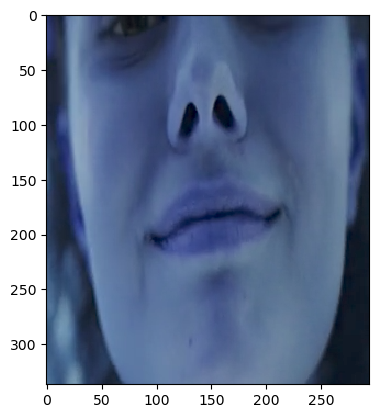

In [15]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Display the image on the axis
#frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
ax.imshow(frame[y_new:y_new+h_new, x_new:x_new+w_new])

plt.show()

In [14]:
engine_dir = '/home/gzguevara/laser/engines/landmarks.trt'
engine     = get_engine(engine_dir)
inputs, outputs, bindings = allocate_buffers_um_pinned(engine)
stream = cuda.Stream()

In [15]:
framee = cv2.resize(framee, (80,80))

In [16]:
# Convert the image to grayscale
framee = cv2.cvtColor(framee, cv2.COLOR_BGR2GRAY)

In [18]:
framee.shape

(80, 80)

In [19]:
with engine.create_execution_context() as context:

    np.copyto(inputs[0], framee.ravel())
    context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    stream.synchronize()

In [20]:
coor = outputs[1].reshape((80,2))

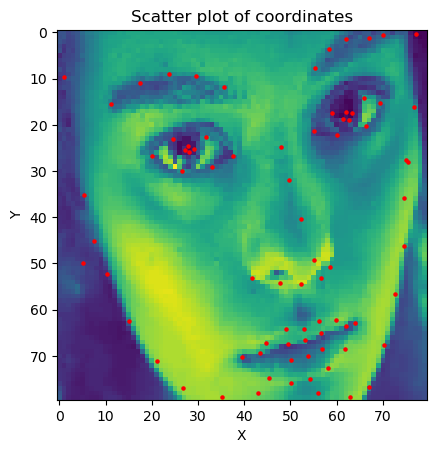

In [22]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Display the image on the axis
#frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
ax.imshow(framee)

# Plot the coordinates
ax.scatter(coor[:,0], coor[:,1], s=5, c='r')

# Add axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter plot of coordinates')

plt.show()